This is a script with instructions to read and plot the .lis outputs from the Athena 4.2 particle module. The structure is adapted (by P. Pjanka) from the \*.m files within this folder.

In [25]:
from particles import *

100%|██████████| 10001/10001 [00:00<00:00, 10965.41it/s]


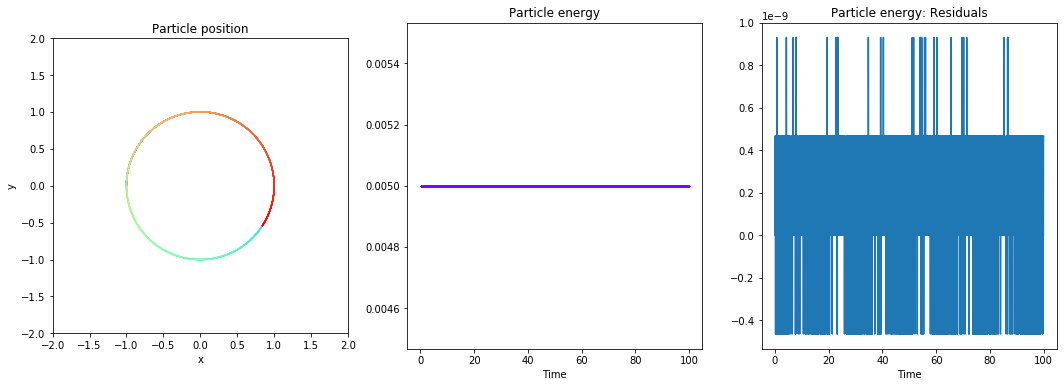

In [27]:
# path to folder containing the .lis files
datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2-particles/bin/test007_Lorentz_VL-SR_gyro/'

filenames = sorted(glob.glob(datapath + '*.lis'))

particles = Particles(relativistic=False)
for filename in tqdm(filenames):
    particles.add_snapshot(filename, verbose=False)
    
fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,3)

plt.subplot(gs[0,0])
ax = plt.gca()
particles.plot_pos2D(ax, color_by='time')
ax.set_aspect(1.0)
ax.set_xlim(-2.,2.)
ax.set_ylim(-2.,2.)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle position')

particles.update_aux_data()

plt.subplot(gs[0,1])
ax = plt.gca()
particles.plot_Ekin_vs_time(ax)
plt.title('Particle energy')
plt.xlabel('Time')

plt.subplot(gs[0,2])
ax = plt.gca()
plt.plot(particles.times, (particles.Ekin - np.mean(particles.Ekin))[:,0])
plt.title('Particle energy: Residuals')
plt.xlabel('Time')

plt.show()
plt.close()